In [ ]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing

# загрузим данные
df = pd.read_csv('data/segmented_customers.csv')
# посмотрим на данные
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [2]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [ ]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender',
                    'Age': 'age', 'Annual Income (k$)': 'annual_income',
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [4]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


In [ ]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df,
    x = 'age',
    y = 'annual_income',
    z = 'spending_score',
    width=1000,
    height=700
)

#отображаем график
fig.show()

In [ ]:
#Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию.
# Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации.
# Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score),
# зафиксируем их названия внутри функции:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df,
        x = 'age',
        y = 'annual_income',
        z = 'spending_score',
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [7]:
#Сохраним признаки, по которым будем проводить моделирование, в переменную X:
X = df[['age', 'annual_income', 'spending_score']]

In [ ]:
#Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию. Сколько кластеров у вас получилось?
# импортируем DBSCAN кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
clustering = DBSCAN().fit(X)


# Далее можно визуализировать результаты, как мы делали с алгоритмом k-means
get_3d_visualization(X, clustering.labels_)
#Ответ - 1

In [ ]:
#Как видно, алгоритм плохо работает с настройками по умолчанию, поэтому попробуем изменить их.
#Большая часть наших данных разрежённые, а чем больше разброс точек в датасете,
# тем большее значение радиуса вокруг точки (eps) нужно задавать.
# Так как данные разрежённые, попробуем увеличить значение eps до 11 и визуально оценим результат:

#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

In [16]:
dbscan = DBSCAN(eps=12)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_12'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_12')


In [13]:
dbscan = DBSCAN(eps=22)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_22'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_22')

Распределение данных неоднородно: в одной области они имеют высокую плотность, в другой области — разряжены. Такие данные не подходят для успешной кластеризации алгоритмом DBSCAN.4

Много точек, которые должны относиться к кластеру, были размечены как выбросы (синие точки).
Такое происходит потому, что данные неоднородны: в некоторых областях они разряжены, а в других имеют большую плотность. Поэтому данный способ, основанный на плотности, не очень подходит для кластеризации.

Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [ ]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward') ##single, ward, average, complete
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

Теперь, вооружившись знаниями из юнита про иерархическую кластеризацию, самостоятельно проведите агломеративную кластеризацию, воспользовавшись функцией, которую мы только что написали. После этого визуализируйте полученную дендрограмму. Количество кластеров для кластеризации укажите равным 3 (на данном этапе это не очень важно).

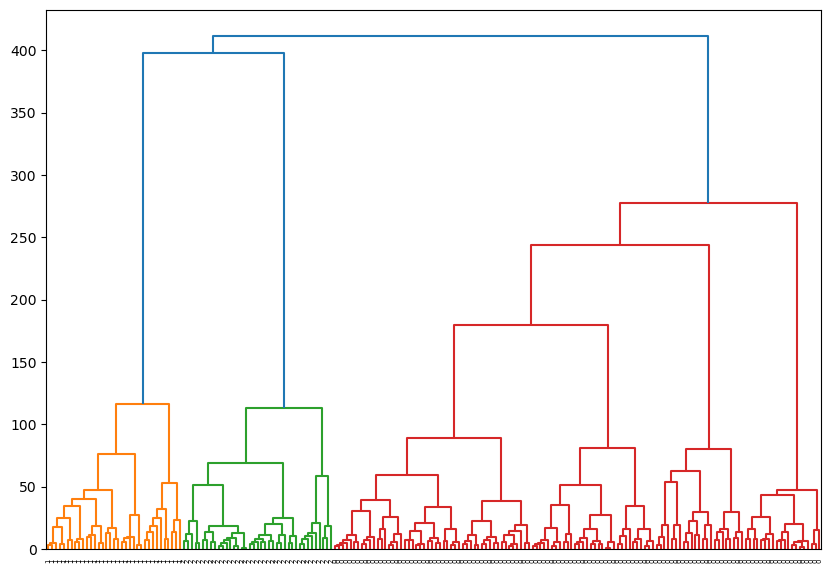

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X,'ward') #single, complete, average, weighted, centroid, median, ward


plt.figure(figsize=(10, 7))

dendrogram(linked,
           orientation='top',
           labels=get_aggl_clustering(X,3),
           distance_sort='descending',
           show_leaf_counts=True)

plt.show()

Как мы можем судить из дендрограммы, если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на шесть кластеров.

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

In [22]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

Итак, кластеры разделились хорошо.

Теперь давайте воспользуемся коэффициентом силуэта и узнаем оптимальное количество кластеров. Совпадает ли это число с тем, что мы подобрали, используя дендрограмму?

<Axes: xlabel='cluster', ylabel='silhouette'>

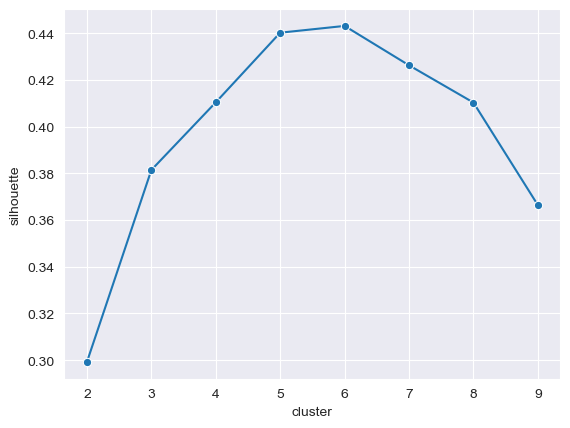

In [26]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    # проведём агломеративную кластеризацию с заданным количеством кластеров
    res = get_aggl_clustering(X, cluster_num)
    # рассчитаем коэффициент силуэта
    silhouette = silhouette_score(X, res)
    return silhouette


# создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg_clust(X, cluster_num))
    silhouette_res["cluster"].append(cluster_num)

# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o")

Как видим, пик коэффициента силуэта находится на значении 6. Таким образом, оптимальное количество кластеров — 6.

In [27]:
#Метрику полноты можно вызвать из модуля cluster библиотеки sklearn. Метрика рассчитывается следующим образом:

from sklearn.metrics.cluster import completeness_score

print(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))
# 0.9012847747610448

0.9012847747610448


Судя по значению метрики, кластеризация проведена отлично: кластеры получились наполненными элементами, а значит данные результаты можно дальше использовать для анализа.